In [181]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import ToTensor

from tqdm import tqdm, trange

from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

from numpy.typing import NDArray
from typing import Tuple

np.random.seed(0)
torch.manual_seed(0)

RSEED = 0
BATCH = 32

In [182]:
with ZipFile("Colorectal_Histology.zip", "r") as zObject:
    zObject.extractall(path=".")

In [183]:
# df = pd.read_csv("hmnist_64_64_L.csv")
# X = df.drop('label', axis=1)
# X = X.to_numpy()
# y = df.label.to_numpy()


In [184]:
root_path =  ".\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000"
list_labels = os.listdir(root_path)

df = pd.DataFrame()
labels = []
id_to_label = {}
pics = []
for idx, label in enumerate(list_labels):
    id_to_label[idx] = label
    pics_in_label = os.listdir(f"{root_path}\\{label}")
    for pic in pics_in_label:
        labels.append(idx)
        pics.append(plt.imread(f"{root_path}\\{label}\\{pic}"))



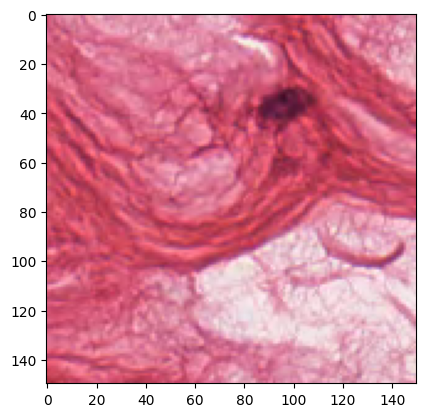

In [185]:
image_np = np.array(pics[1000])
plt.imshow(image_np)

In [186]:
X = np.array(pics)
y = np.array(labels)

In [187]:
type(y)

numpy.ndarray

In [188]:
class histo(Dataset):
    def __init__(self, X:NDArray[np.int8], y:NDArray[np.int8])->None:
        X = torch.tensor(X, dtype=torch.uint8)
        self.X = X.float()/255
        if y is None:
            self.y = None
        else:
            self.y = y

    def __len__(self)->int:
        return len(self.X)
    
    def __getitem__(self, idx:int)->int:
        return self.X[idx], self.y[idx]
    
    @staticmethod
    def create_split(X, y, train_fraction:float, val_fraction:float, test_fraction:float)->Tuple[Dataset, Dataset, Dataset]:
        assert train_fraction + val_fraction + test_fraction <= 1

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_fraction)

        train_data = histo(X_train, y_train)
        val_data = histo(X_val, y_val)

        return train_data, val_data


In [189]:
train_data, val_data = histo.create_split(X, y, 0.5, 0.5,0.0)

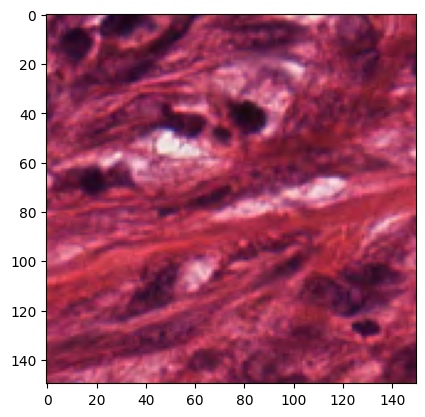

In [190]:
image = train_data[7][0]
image_np = image.numpy()
plt.imshow(image_np)

In [191]:
def make_patches(images, num_patches):
    n = len(images)
    h, w, c = images[0][0].size()
    print(n,h, w, c)
 

    assert h == w

    patches = torch.zeros(n, num_patches**2, h*w*c//num_patches**2)
    patch_size = h//num_patches

    for idx, image in enumerate(images):
       
        for i in range(num_patches):
            for j in range(num_patches):
                patch = image[0][i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
                patches[idx, i*num_patches+j] = patch.flatten()
    return patches

In [192]:
class ViTModel(nn.Module):
    def __init__(self, chw=(1,150,150), num_patches=7):
        super(ViTModel, self).__init__()

        self.chw = chw
        self.num_patches = num_patches

        assert chw[1] % num_patches == 0
        assert chw[2] % num_patches == 0

        self.patch_size = (chw[1]/ num_patches, chw[2]/num_patches)

        self.input_dimensions = int(chw[0],*self.patch_size[0]*self.patch_size[1])
        self.hidden_dimension = self.input_dimensions
        self.linear_mapper = nn.Linear(self.input_dimensions, self.hidden_dimension)

        self.class_token = nn.Parameter(torch.rand(1, self.hidden_dimension))



    def foward(self, images):
        patches = make_patches(images, self.num_patches)
        tokens = self.linear_mapper(patches)
        tokens = torch.stack([torch.vvstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        return tokens

In [2]:
def positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i/(10000**(j/d))) if j%2 == 0 else np.cos(i/(1000*((j-1)/d)))
    return result

In [193]:
all_patches = make_patches(train_data, 15)

2500 150 150 3


In [194]:
def  main():


    train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ViTModel((3, 150, 150), n_patches=16, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    num_epochs = 4
    learn_rate = 0.005

    optimizer = Adam(model.parameters(), lr=learn_rate)
    loss_fn = CrossEntropyLoss()

    for epoch in trange(num_epochs, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch +1} in training", leave=False):
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            train_loss += loss.detach().cpu().item()/len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} loss: {train_loss:.3f}")

        with torch.no_grad():
            correct, total = 0,  0

            test_loss = 0.0

            for batch in tqdm(val_loader, desc="Testing"):
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_pred = model(X)

                loss = loss_fn(y_pred, y)

                test_loss += loss.detach().cpu().item()/len(val_loader)

                correct += torch.sum(torch.argmax(y_pred, dim=1)==y).detach().cpu().item()
                total += len(X)
            print(f"Test loss: {test_loss:.3f}")
            print(f"Test accuracy: {correct/total*100:.3f}")

In [195]:
all_patches[1].size()

torch.Size([225, 300])